# Word2Vec

In [1]:
# # utilisation dans Google collab
# print('Mounting your Google Drive...')
# from google.colab import drive
# drive.mount('/content/drive')
# print('Opening the file...')
# %cd /content/drive/My Drive/P7
# !ls

In [2]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [3]:
import multiprocessing
# Paramètres du modèle Word2Vec
w2v_size = 300        # Taille des vecteurs
w2v_window = 5        # Taille de la fenêtre contextuelle
w2v_min_count = 1     # Nombre minimum d'occurrences d'un mot pour être pris en compte
w2v_epochs = 100      # Nombre d'itérations (époques)
workers = multiprocessing.cpu_count()  # Utilisation de tous les cœurs disponibles

### Données

In [4]:
import pandas as pd

train_df = pd.read_csv("./data/train_df.csv")
train_df = train_df.iloc[:, 1:]
test_df = pd.read_csv("./data/test_df.csv")
test_df = test_df.iloc[:, 1:]

### Préparation des sentences

In [5]:
# Préparation des sentences à partir de la colonne 'preprocessed_text'
# Tokenisation de chaque phrase en séparant les mots sur les espaces
train_sentences = [sentence.split() for sentence in train_df['preprocessed_text'].astype(str)]
test_sentences = [sentence.split() for sentence in test_df['preprocessed_text'].astype(str)]

### Modèle Word2Vec

In [6]:
from gensim.models import Word2Vec
# Instanciation du modèle Word2Vec
w2v_model = Word2Vec(
    sentences=train_sentences,   # Les phrases tokenisées d'entraînement
    vector_size=w2v_size,        # Taille des vecteurs
    window=w2v_window,           # Taille de la fenêtre contextuelle
    min_count=w2v_min_count,     # Seuil d'apparition minimum d'un mot
    workers=workers,             # Nombre de threads (CPU cores) à utiliser
    sg=1                         # Utilisation de Skip-gram (si sg=0, on utilise CBOW)
)

In [7]:
# Entraînement du modèle
w2v_model.train(train_sentences, total_examples=len(train_sentences), epochs=w2v_epochs)


(2804158, 3447500)

In [8]:
# Sauvegarde du modèle après entraînement
w2v_model.save("./models/word2vec_model.model")

### Matrice d'embeddings

In [9]:
# Taille du vocabulaire (le nombre de mots uniques)
vocab_size = len(w2v_model.wv.index_to_key)

# Extraction de la matrice d'embedding
embedding_matrix = []
for word in w2v_model.wv.index_to_key:
    embedding_matrix.append(w2v_model.wv[word])

# Conversion en numpy array
import numpy as np
embedding_matrix = np.array(embedding_matrix)

# Dimensions de la matrice d'embedding : vocab_size x w2v_size
print("Matrice d'embedding de taille :", embedding_matrix.shape)

Matrice d'embedding de taille : (6006, 300)


### Modèle d'embedding Keras

Les essais avec un modèle simple (LSTM et dense) ont montré un sur-apprentissage important. Il faut l'optimiser avec dropout, regularisation.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Paramètres
maxlen = 40  # Longueur maximale des séquences de mots
vocab_size = len(w2v_model.wv.index_to_key)  # Taille du vocabulaire

In [11]:
# Instanciation du modèle séquentiel 1
model = Sequential()

# Ajout de la couche d'embedding avec la matrice pré-entraînée
model.add(Embedding(
    input_dim=vocab_size,       # Taille du vocabulaire
    output_dim=w2v_size,        # Dimension des vecteurs d'embedding
    weights=[embedding_matrix], # Utilisation de la matrice d'embedding pré-entraînée
    trainable=False             # Geler les poids de l'embedding
))

# Ajout d'une couche LSTM pour capturer les relations séquentielles
model.add(LSTM(128))

# Ajout d'une couche de sortie (par exemple, pour de la classification binaire)
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,801,800 (6.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,801,800 (6.87 MB)

In [12]:
# Instanciation du modèle séquentiel 2
from tensorflow.keras.regularizers import l2

# Ajout de la régularisation L2 dans la couche LSTM et la couche Dense
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                    trainable=False))
model.add(LSTM(128, kernel_regularizer=l2(0.01)))  # Ajout de la régularisation L2
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # Ajout L2 dans la couche Dense

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Affichage du résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,801,800 (6.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,801,800 (6.87 MB)

In [13]:
# Modèle 3 avec dropout

from tensorflow.keras.layers import Dropout

# Ajout de Dropout après la couche LSTM pour prévenir l'overfitting
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                    trainable=False))
model.add(LSTM(128))
model.add(Dropout(0.5))  # Dropout de 50% des neurones
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,801,800 (6.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,801,800 (6.87 MB)

In [14]:
# diminuer la complexité LSTM ou utiliser GRU
# Réduction du nombre d'unités dans la couche LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                    input_length=maxlen, trainable=False))
model.add(LSTM(64))  # Moins d'unités LSTM
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# Code du modèle avec GRU, Dropout et régularisation L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Importer Adam pour ajuster le learning rate

# Paramètres de régularisation et Dropout
dropout_rate = 0.5      # Pourcentage de neurones ignorés
l2_lambda = 0.01        # Facteur de régularisation L2
learning_rate = 0.0001  # Taux d'apprentissage spécifique

# Instanciation du modèle séquentiel
model = Sequential()

# 1. Couche d'embedding avec la matrice Word2Vec pré-entraînée
model.add(Embedding(
    input_dim=vocab_size,       # Taille du vocabulaire
    output_dim=w2v_size,        # Dimension des vecteurs d'embedding
    weights=[embedding_matrix], # Matrice d'embedding pré-entraînée
    input_length=maxlen,        # Longueur maximale des séquences
    trainable=False             # Geler les poids de l'embedding
))

# 2. Couche GRU avec Dropout et régularisation L2
model.add(GRU(
    units=128,                    # Nombre d'unités GRU
    kernel_regularizer=l2(l2_lambda),  # Régularisation L2 sur les poids
    recurrent_regularizer=l2(l2_lambda),  # Régularisation L2 sur les poids récurrents
    dropout=dropout_rate,         # Dropout sur les connexions entrantes
    recurrent_dropout=dropout_rate  # Dropout sur les connexions récurrentes
))

# 3. Couche de sortie Dense avec régularisation L2
model.add(Dense(
    units=1,                      # Pour une tâche de classification binaire
    activation='sigmoid',          # Sigmoid pour la probabilité binaire
    kernel_regularizer=l2(l2_lambda)  # Régularisation L2 sur la couche de sortie
))

# Définir l'optimiseur Adam avec un learning rate spécifique
optimizer = Adam(learning_rate=learning_rate)

# Compilation du modèle
model.compile(
    optimizer=optimizer,          # Utiliser l'optimiseur Adam avec le learning rate défini
    loss='binary_crossentropy',   # Fonction de perte pour une classification binaire
    metrics=['accuracy']          # Métrique d'accuracy
)

# Affichage du résumé du modèle
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,801,800 (6.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,801,800 (6.87 MB)

### Préparation des données pour l'exécution du modèle

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Création d'un dictionnaire mot->index à partir du vocabulaire de Word2Vec
word_index = {word: i for i, word in enumerate(w2v_model.wv.index_to_key)}

# Fonction pour convertir les phrases en séquences d'index
def sentences_to_sequences(sentences, word_index):
    sequences = []
    for sentence in sentences:
        seq = [word_index.get(word, 0) for word in sentence]  # Remplacer les mots inconnus par 0
        sequences.append(seq)
    return sequences

# Conversion des phrases d'entraînement et de test en séquences d'index
train_sequences = sentences_to_sequences(train_sentences, word_index)
test_sequences = sentences_to_sequences(test_sentences, word_index)

# Padding des séquences pour qu'elles aient toutes la même longueur (maxlen)
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

# Exemple d'affichage des séquences après padding
print(train_padded[:5])


[[ 165   65  990 2556 2546  957    6  167 1161  419  867 1145   32 2684
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 406   16  750    3    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2726  838   28  101   32    4   14    5   86    5   41  101   72   90
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2520 2594 2424  450   54  612  193 2549   19    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1 2618 2686    5  419    5   55  105  177   81    6  179  496  239
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

### Entrainement du modèle d'embedding

In [17]:
y_train = train_df['target'].values
y_test = test_df['target'].values

In [18]:
# Entraînement du modèle avec validation et sauvegarde de l'historique
history = model.fit(
    train_padded,         # Données d'entraînement
    y_train,              # Étiquettes d'entraînement
    epochs=5,            # Nombre d'époques
    batch_size=32,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les données de test
    verbose=1             # Afficher l'évolution pendant l'entraînement
)

Epoch 1/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5042 - loss: 1951987456.0000 - val_accuracy: 0.5014 - val_loss: 5.3476
Epoch 2/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5250 - loss: 1085461760.0000 - val_accuracy: 0.5014 - val_loss: 5.3395
Epoch 3/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5001 - loss: 831489984.0000 - val_accuracy: 0.5014 - val_loss: 5.3317
Epoch 4/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4901 - loss: 674716096.0000 - val_accuracy: 0.5014 - val_loss: 5.3264
Epoch 5/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4837 - loss: 534698944.0000 - val_accuracy: 0.5014 - val_loss: 5.3225


In [19]:
# pip install plot-keras-history
# Source: @software{Cappelletti_Plot_Keras_History_2022,
#     author = {Cappelletti, Luca},
#     doi = {10.5072/zenodo.1054923},
#     month = {4},
#     title = {{Plot Keras History}},
#     version = {1.1.36},
#     year = {2022}
# }

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

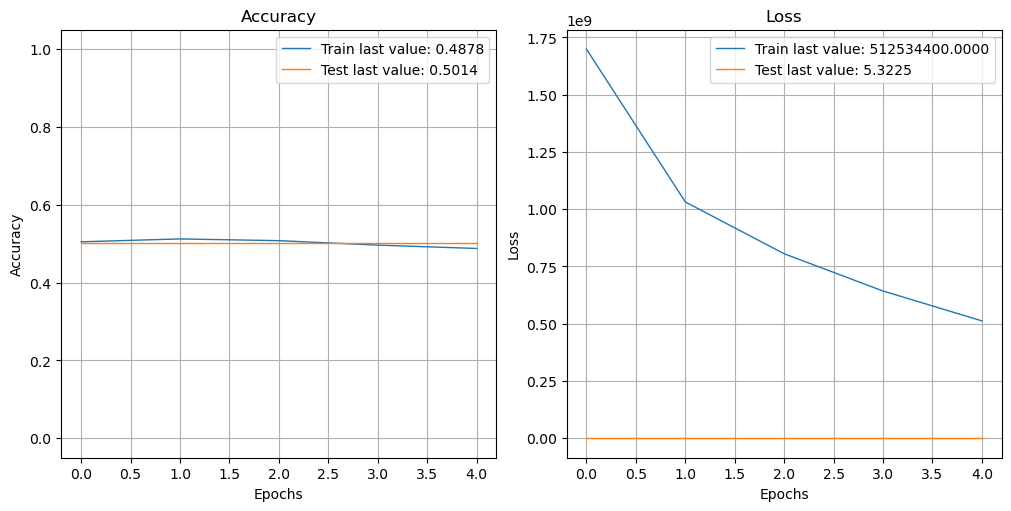

In [21]:
from plot_keras_history import plot_history

# Plot de l'historique de l'entraînement
plot_history(history.history)

### Optimisation automatique du modèle d'embedding

Utilisation de <u><b>Keras tuner</b></u> pour optimiser le modèle en faisant varier:<br>
- le nombre d'unités GRU
- le taux de dropout
- la régularisation L2
- le taux d'apprentissage

In [22]:
# pip install keras-tuner --upgrade

In [23]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Fonction de création du modèle pour Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # 1. Couche d'embedding avec la matrice Word2Vec pré-entraînée
    model.add(Embedding(
        input_dim=vocab_size,        
        output_dim=w2v_size,         
        weights=[embedding_matrix],  
        # input_length=maxlen,         
        trainable=False              
    ))

    # 2. Couche LSTM bidirectionnelle avec des hyperparamètres tunables
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=64, max_value=256, step=32),
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log')),  # Intervalle élargi
        recurrent_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log')),
        dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),  # Dropout plus élevé
        recurrent_dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),
        return_sequences=False
    )))

    # 3. Couche de sortie Dense avec régularisation L2
    model.add(Dense(
        units=1,                      
        activation='sigmoid',          
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log'))
    ))

    # Optimiseur Adam avec un learning rate tunable
    optimizer = Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))

    # Compilation du modèle
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instanciation du tuner pour rechercher les hyperparamètres
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='lstm_bidirectional_tuning'
)

# Callbacks avec `restore_best_weights`
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recherche des meilleurs hyperparamètres
tuner.search(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])

# Récupération des meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Entraîner le meilleur modèle avec ces hyperparamètres
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])


Reloading Tuner from my_dir\lstm_bidirectional_tuning\tuner0.json
Epoch 1/20


C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5675 - loss: 0.7197 - val_accuracy: 0.6484 - val_loss: 0.6422
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6194 - loss: 0.6592 - val_accuracy: 0.6435 - val_loss: 0.6328
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6601 - loss: 0.6321 - val_accuracy: 0.6765 - val_loss: 0.6289
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6736 - loss: 0.6197 - val_accuracy: 0.6751 - val_loss: 0.6191
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6971 - loss: 0.5955 - val_accuracy: 0.7074 - val_loss: 0.5899
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7228 - loss: 0.5746 - val_accuracy: 0.6930 - val_loss: 0.5898
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7357 - loss: 0.5616 - val_accuracy: 0.7067 - val_loss: 0.5893
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7284 - loss: 0.5541 - val_accuracy: 0.696

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

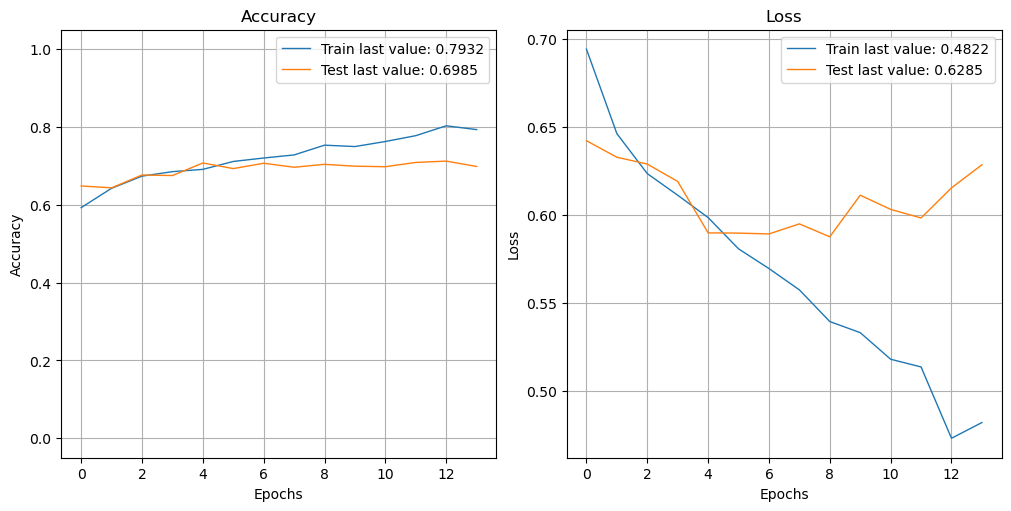

In [24]:
# Plot de l'historique de l'entraînement
plot_history(history.history)

In [25]:
# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés :")
print(f" - Units dans LSTM : {best_hps.get('units')}")
print(f" - Lambda de régularisation L2 : {best_hps.get('l2_lambda')}")
print(f" - Dropout rate : {best_hps.get('dropout_rate')}")
print(f" - Learning rate : {best_hps.get('learning_rate')}")

# Construire le meilleur modèle avec les meilleurs hyperparamètres
# Spécifier l'input_shape correspondant à tes données (par exemple `maxlen`)
input_shape = (maxlen,)  # Nombre max de tokens

# "Build" le modèle explicitement avec la taille d'entrée
best_model.build(input_shape=(None, *input_shape))  # None correspond à la taille du batch

# Affichage du résumé du modèle
best_model.summary()

Meilleurs hyperparamètres trouvés :
 - Units dans LSTM : 160
 - Lambda de régularisation L2 : 2.2473833926205203e-05
 - Dropout rate : 0.5
 - Learning rate : 0.002077190408327862


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 40, 300)             │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 320)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             321 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,573,005 (13.63 MB)

 Trainable params: 590,401 (2.25 MB)

 Non-trainable params: 1,801,800 (6.87 MB)

 Optimizer params: 1,180,804 (4.50 MB)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


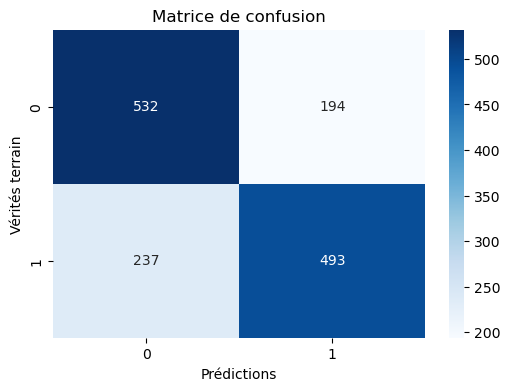

Rapport de classification :
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       726
           1       0.72      0.68      0.70       730

    accuracy                           0.70      1456
   macro avg       0.70      0.70      0.70      1456
weighted avg       0.70      0.70      0.70      1456



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des prédictions sur le jeu de test
y_pred_probs = best_model.predict(test_padded)  # Prédictions en probabilités
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.show()

# 4. Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


# Modèle basé sur Bert (pré-entrainé)

In [19]:
# pip install transformers torch

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to preprocess the text and make predictions
def predict_sentiment(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted sentiment label
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Map the prediction to the sentiment
    sentiment_labels = ['negative', 'neutral', 'positive']
    return sentiment_labels[predicted_class]

# Example usage
text = "I love using the new RoBERTa model for sentiment analysis!"
sentiment = predict_sentiment(text)
print(f"Sentiment: {sentiment}")


C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sentiment: positive


In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Load the tokenizer and model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to predict sentiment
def predict_sentiment_roberta(texts):
    # Tokenize the input texts
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class
    logits = outputs.logits
    predicted_classes = torch.argmax(logits, dim=1)

    return predicted_classes

# Mapping the RoBERTa outputs to your target classes (0 = positive, 1 = negative)
def map_roberta_to_custom_labels(roberta_prediction):
    # RoBERTa has 3 classes: [negative, neutral, positive]
    # We'll map neutral and negative to 'negative' (1), positive to 'positive' (0)
    return 1 if roberta_prediction in [0, 1] else 0

# Process the DataFrame and predict sentiments for train/test data
def process_and_predict(df):
    predicted_labels = []

    for text in df['text']:
        # Predict sentiment for each tweet
        roberta_prediction = predict_sentiment_roberta([text])[0].item()

        # Map RoBERTa sentiment to custom labels
        custom_label = map_roberta_to_custom_labels(roberta_prediction)
        predicted_labels.append(custom_label)

    return predicted_labels

# Predict on training set
train_predictions = process_and_predict(train_df)
train_labels = train_df['target'].tolist()

# Predict on test set
test_predictions = process_and_predict(test_df)
test_labels = test_df['target'].tolist()

# Evaluate the results
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

# Classification report for further insights
print("\nClassification Report on Train Data:")
print(classification_report(train_labels, train_predictions, target_names=["positive", "negative"]))

print("\nClassification Report on Test Data:")
print(classification_report(test_labels, test_predictions, target_names=["positive", "negative"]))


C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Train Accuracy:  0.6989690721649484
Test Accuracy:  0.7019230769230769

Classification Report on Train Data:
              precision    recall  f1-score   support

    positive       0.78      0.56      0.65      1694
    negative       0.66      0.84      0.74      1701

    accuracy                           0.70      3395
   macro avg       0.72      0.70      0.69      3395
weighted avg       0.72      0.70      0.69      3395


Classification Report on Test Data:
              precision    recall  f1-score   support

    positive       0.78      0.56      0.65       726
    negative       0.66      0.85      0.74       730

    accuracy                           0.70      1456
   macro avg       0.72      0.70      0.70      1456
weighted avg       0.72      0.70      0.70      1456



# Test Roberta tweets sentiment analysis avec fine-tuning

In [22]:
import torch
print("CUDA disponible:", torch.cuda.is_available())  # Devrait retourner True
print("Nom du GPU:", torch.cuda.get_device_name(0))   # Affiche le nom du GPU
print("Version de PyTorch:", torch.__version__)       # Devrait afficher 2.4.1


CUDA disponible: True
Nom du GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Version de PyTorch: 2.4.1+cu118


In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load the tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
# Freeze all layers except the last classification layer
for param in model.base_model.parameters():
    param.requires_grad = False

In [25]:
import torch
from torch.utils.data import Dataset

# Custom Dataset class to handle tokenization
class TweetDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        target = self.targets[index]

        # Tokenization
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [26]:
# # Sous-échantillonage de train_df
# from sklearn.model_selection import train_test_split

# # Taille de l'échantillon (20% du total)
# sample_size = 0.2

# # Création du sous-échantillon avec stratification sur la colonne 'target'
# train_sample, _ = train_test_split(train_df,
#                                    test_size=1 - sample_size,
#                                    stratify=train_df['target'],
#                                    random_state=42)

# # Affichage de la répartition des classes dans le sous-échantillon
# print(train_sample['target'].value_counts(normalize=True))

In [27]:
# Recap modèle et assignation de device pour le calcul
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [28]:
from tweet_dataset import TweetDataset  # Importer la classe depuis le module séparé

# Function to create the DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = TweetDataset(
        texts=df['text'].to_numpy(),
        targets=df['target'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4  # Adjust according to your machine
    )

In [29]:
# Main execution block
if __name__ == "__main__":
    maxlen = 40  # Max tokens
    batch_size = 16  # Increase to lower calculation time

    # Prepare the data
    train_dataloader = create_data_loader(train_df, tokenizer, maxlen, batch_size)
    test_dataloader = create_data_loader(test_df, tokenizer, maxlen, batch_size)
    # Example usage of DataLoader (test de l'utilisation de la classe tweet_dataset
    # for batch in train_dataloader:
    #     print(batch)
    #     break  # Remove this line to process the full dataset

In [30]:
from torch.optim import AdamW
# Optimizer and learning rate (adjustable)
optimizer = AdamW(model.parameters(), lr=0.0001)

In [31]:
# Training function
def train_epoch(model, dataloader, optimizer, device):
    model = model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=targets
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        total_correct += torch.sum(preds == targets)
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()

    return total_correct.double() / total_samples, total_loss / total_samples

# Evaluation function
def eval_model(model, dataloader, device):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == targets)
            total_samples += targets.size(0)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    accuracy = total_correct.double() / total_samples
    return accuracy, predictions, true_labels

In [32]:
epochs = 20  # Adjust as necessary

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device)
    print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/20 | Train Loss: 0.0356 | Train Accuracy: 0.7337
Epoch 2/20 | Train Loss: 0.0294 | Train Accuracy: 0.7797
Epoch 3/20 | Train Loss: 0.0291 | Train Accuracy: 0.7797
Epoch 4/20 | Train Loss: 0.0288 | Train Accuracy: 0.7797
Epoch 5/20 | Train Loss: 0.0288 | Train Accuracy: 0.7859
Epoch 6/20 | Train Loss: 0.0283 | Train Accuracy: 0.7850
Epoch 7/20 | Train Loss: 0.0282 | Train Accuracy: 0.7862
Epoch 8/20 | Train Loss: 0.0277 | Train Accuracy: 0.7882
Epoch 9/20 | Train Loss: 0.0282 | Train Accuracy: 0.7838
Epoch 10/20 | Train Loss: 0.0279 | Train Accuracy: 0.7885
Epoch 11/20 | Train Loss: 0.0279 | Train Accuracy: 0.7829
Epoch 12/20 | Train Loss: 0.0279 | Train Accuracy: 0.7826
Epoch 13/20 | Train Loss: 0.0278 | Train Accuracy: 0.7929
Epoch 14/20 | Train Loss: 0.0276 | Train Accuracy: 0.7912
Epoch 15/20 | Train Loss: 0.0276 | Train Accuracy: 0.7912
Epoch 16/20 | Train Loss: 0.0276 | Train Accuracy: 0.7938
Epoch 17/20 | Train Loss: 0.0277 | Train Accuracy: 0.7882
Epoch 18/20 | Train Los

In [33]:
# import torch
# import numpy as np
# from sklearn.metrics import recall_score
# import matplotlib.pyplot as plt

# # Function to calculate recall (as a callback metric)
# def calculate_recall(y_true, y_pred):
#     y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
#     y_true = y_true.cpu().numpy()
#     return recall_score(y_true, y_pred, average='macro')

In [34]:
# # Train and evaluation function
# def train_epoch(model, dataloader, optimizer, device):
#     model.train()
#     losses = []
#     correct_predictions = 0
#     total_predictions = 0

#     for batch in dataloader:
#         optimizer.zero_grad()
#         inputs = batch['input_ids'].to(device)
#         masks = batch['attention_mask'].to(device)
#         targets = batch['targets'].to(device)

#         outputs = model(input_ids=inputs, attention_mask=masks).logits
#         loss = torch.nn.CrossEntropyLoss()(outputs, targets)
        
#         _, preds = torch.max(outputs, dim=1)
#         correct_predictions += torch.sum(preds == targets)
#         total_predictions += targets.size(0)

#         loss.backward()
#         optimizer.step()

#         losses.append(loss.item())

#     return correct_predictions.double() / total_predictions, np.mean(losses)

# def eval_model(model, dataloader, device):
#     model.eval()
#     losses = []
#     correct_predictions = 0
#     total_predictions = 0
#     recalls = []

#     with torch.no_grad():
#         for batch in dataloader:
#             inputs = batch['input_ids'].to(device)
#             masks = batch['attention_mask'].to(device)
#             targets = batch['targets'].to(device)

#             outputs = model(input_ids=inputs, attention_mask=masks).logits
#             loss = torch.nn.CrossEntropyLoss()(outputs, targets)

#             _, preds = torch.max(outputs, dim=1)
#             correct_predictions += torch.sum(preds == targets)
#             total_predictions += targets.size(0)
            
#             # Recall calculation
#             recalls.append(calculate_recall(targets, outputs))

#             losses.append(loss.item())

#     return correct_predictions.double() / total_predictions, np.mean(losses), np.mean(recalls)

In [35]:
# # Training loop with callbacks, early stopping and history tracking
# def train_model(model, train_dataloader, test_dataloader, optimizer, epochs, device, patience=3):
#     history = {
#         'train_loss': [],
#         'test_loss': [],
#         'train_recall': [],
#         'test_recall': []
#     }

#     best_recall = 0
#     early_stopping_counter = 0

#     for epoch in range(epochs):
#         # Training
#         train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device)
#         # Evaluation
#         test_acc, test_loss, test_recall = eval_model(model, test_dataloader, device)
        
#         # Save metrics to history
#         history['train_loss'].append(train_loss)
#         history['test_loss'].append(test_loss)
#         history['train_recall'].append(train_acc)
#         history['test_recall'].append(test_recall)

#         # Print progress
#         print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Recall: {test_recall:.4f}')

#         # Early stopping based on loss improvement
#         if test_recall > best_recall:
#             best_recall = test_recall
#             early_stopping_counter = 0
#             # Optionally save the best model here
#             torch.save(model.state_dict(), 'best_model.pth')
#         else:
#             early_stopping_counter += 1

#         if early_stopping_counter >= patience:
#             print(f"Early stopping after {epoch + 1} epochs")
#             break

#     # Save history to a file
#     with open('history.npy', 'wb') as f:
#         np.save(f, history)

#     # Plot loss and recall
#     plot_history(history)

In [36]:
# def plot_history(history):
#     epochs = len(history['train_loss'])
#     plt.figure(figsize=(14, 5))

#     # Plot loss
#     plt.subplot(1, 2, 1)
#     plt.plot(range(epochs), history['train_loss'], label='Train Loss')
#     plt.plot(range(epochs), history['test_loss'], label='Test Loss')
#     plt.legend()
#     plt.title('Loss Evolution')
    
#     # Plot recall
#     plt.subplot(1, 2, 2)
#     plt.plot(range(epochs), history['train_recall'], label='Train Recall')
#     plt.plot(range(epochs), history['test_recall'], label='Test Recall')
#     plt.legend()
#     plt.title('Recall Evolution')

#     plt.show()

In [37]:
# train_model(model, train_dataloader, test_dataloader, optimizer, epochs=5, device=device)

In [38]:
# Evaluate the model on the test set
test_acc, test_preds, test_true = eval_model(model, test_dataloader, device)
print(f'Test Accuracy: {test_acc:.4f}')

# Classification report
print("\nClassification Report on Test Data:")
print(classification_report(test_true, test_preds, target_names=["positive", "negative"]))

Test Accuracy: 0.7960

Classification Report on Test Data:
              precision    recall  f1-score   support

    positive       0.78      0.83      0.80       726
    negative       0.82      0.77      0.79       730

    accuracy                           0.80      1456
   macro avg       0.80      0.80      0.80      1456
weighted avg       0.80      0.80      0.80      1456



In [39]:
from datetime import datetime

# Get current date and time
now = datetime.now()
dt_string = now.strftime("%m_%d_%Y_%H_%M")

# Save the model
model_save_path = f'./models/roberta_fine_tuned_{dt_string}'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to ./models/roberta_fine_tuned_10_14_2024_21_58
